# Step 1: Set Up Google Colab and GCP Integration

## Objective:
Authenticate your Google Colab environment to access your GCP project and Google Cloud Storage (GCS)

In [18]:
!pip install google-cloud-storage google-cloud-bigquery pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.1/240.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 12.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=9e9834d0e82cd2d705ab63a50545b402a9a6f5d0acd72735abc8146e04f99c8e
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ten

### This installs:

google-cloud-storage: For accessing and managing files in GCS.
google-cloud-bigquery: For querying data in BigQuery.
pyspark: For distributed data processing with Spark.

# Step 1.3: Authenticate with GCP
GCP requires authentication to interact with your project. Run the following code to authenticate:

In [19]:
from google.colab import auth
auth.authenticate_user()

# Set up your GCP project
project_id = "brain-tumor-prediction-444202"  # Replace with your GCP project ID
!gcloud config set project {project_id}


Updated property [core/project].


# Step 1.4: Install Java for Spark
Apache Spark requires Java. Install it by running:

In [20]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null


In [ ]:
import os

# Set up environment variables for Java and Spark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

# Download and install Spark
# !wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf /content/spark-3.5.3-bin-hadoop3.tgz


# Step 1.6: Verify Spark Installation
Test that Spark is installed properly by running:

In [ ]:
# Start a local Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BrainTumorPrediction") \
    .getOrCreate()

print("Spark session started:", spark.version)


Spark session started: 3.5.3


# Step 1.7: Access GCS Bucket
Use the GCS client library to list files in your bucket. Replace "braintumor_dataset" with your actual bucket name.

In [36]:
from google.cloud import storage

# Initialize a GCS client
client = storage.Client()

# Access the bucket
bucket_name = "braintumor__dataset"
bucket = client.bucket(bucket_name)

# List files in the bucket
blobs = bucket.list_blobs()
print("Files in bucket:")
for blob in blobs:
    print(blob.name)


Streaming output truncated to the last 5000 lines.
Non Cancer/Not Cancer  (64).jpg
Non Cancer/Not Cancer  (640).jpg
Non Cancer/Not Cancer  (641).jpg
Non Cancer/Not Cancer  (642).jpg
Non Cancer/Not Cancer  (643).jpg
Non Cancer/Not Cancer  (644).jpg
Non Cancer/Not Cancer  (645).jpg
Non Cancer/Not Cancer  (646).jpg
Non Cancer/Not Cancer  (647).jpg
Non Cancer/Not Cancer  (648).jpg
Non Cancer/Not Cancer  (649).jpg
Non Cancer/Not Cancer  (65).jpg
Non Cancer/Not Cancer  (650).jpg
Non Cancer/Not Cancer  (651).jpg
Non Cancer/Not Cancer  (652).jpg
Non Cancer/Not Cancer  (653).jpg
Non Cancer/Not Cancer  (654).jpg
Non Cancer/Not Cancer  (655).jpg
Non Cancer/Not Cancer  (656).jpg
Non Cancer/Not Cancer  (657).jpg
Non Cancer/Not Cancer  (658).jpg
Non Cancer/Not Cancer  (659).jpg
Non Cancer/Not Cancer  (66).jpg
Non Cancer/Not Cancer  (660).jpg
Non Cancer/Not Cancer  (661).jpg
Non Cancer/Not Cancer  (662).jpg
Non Cancer/Not Cancer  (663).jpg
Non Cancer/Not Cancer  (664).jpg
Non Cancer/Not Cancer  (665)

# Step 1.8: Handle Bucket Data
Test accessing files (e.g., download a sample .jpg or .png):

In [ ]:
# Download a sample file from GCS
blob = bucket.blob("Cancer/Cancer (1).jpg")  # Adjust path if needed
blob.download_to_filename("sample.jpg")

print("Downloaded file: sample.jpg")


blob = bucket.blob("Non Cancer/Not Cancer  (1).jpeg")  # Adjust path if needed
blob.download_to_filename("sample.jpeg")

print("Downloaded file: sample1.jpeg")

Downloaded file: sample.jpg
Downloaded file: sample1.jpeg


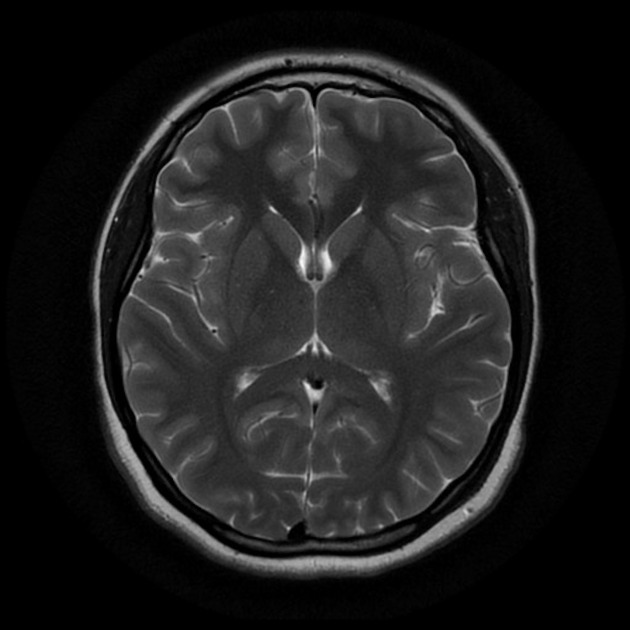

In [ ]:
from IPython.display import Image
# Image("sample.jpg")
Image("sample.jpeg")


# Step 2: Preprocess the Data with Spark
Objective:
Use Spark for distributed preprocessing of image data from your GCS bucket.
Convert .tif images to .jpg or .png format.
Prepare the data for machine learning (resize images, normalize pixel values, and label them).

#Step 2.1: Read Image Metadata from GCS
We will list and categorize image files (e.g., Cancer vs. Non Cancer) from the GCS bucket.

Add the following code to fetch file paths:

In [37]:
from google.cloud import storage

# Define constants
PROJECT_ID = 'brain-tumor-prediction-444202'  # Replace with your GCP project ID
BUCKET_NAME = 'braintumor__dataset'  # Replace with your GCS bucket name
CANCER_FOLDER = 'Cancer/'
NON_CANCER_FOLDER = 'Non Cancer/'

# Initialize GCP Storage client
client = storage.Client(project=PROJECT_ID)
bucket = client.get_bucket(BUCKET_NAME)

# Initialize lists to store file paths
cancer_files = []
non_cancer_files = []

# Fetch image file paths and labels
for blob in bucket.list_blobs():
    print(f"Processing file: {blob.name}")  # Debugging
    file_path = blob.name.strip()  # Strip spaces from names
    if file_path.startswith(CANCER_FOLDER) and file_path.endswith(('.jpg', '.png', '.tif', '.jpeg', '.JPG')):
        cancer_files.append(f"gs://{BUCKET_NAME}/{file_path}")
    elif file_path.startswith(NON_CANCER_FOLDER) and file_path.endswith(('.jpg', '.png', '.tif', '.jpeg', '.JPG')):
        non_cancer_files.append(f"gs://{BUCKET_NAME}/{file_path}")

# Print the results
print("Number of Cancer images:", len(cancer_files))
print("Number of Non-Cancer images:", len(non_cancer_files))


Streaming output truncated to the last 5000 lines.
Processing file: Non Cancer/Not Cancer  (641).jpg
Processing file: Non Cancer/Not Cancer  (642).jpg
Processing file: Non Cancer/Not Cancer  (643).jpg
Processing file: Non Cancer/Not Cancer  (644).jpg
Processing file: Non Cancer/Not Cancer  (645).jpg
Processing file: Non Cancer/Not Cancer  (646).jpg
Processing file: Non Cancer/Not Cancer  (647).jpg
Processing file: Non Cancer/Not Cancer  (648).jpg
Processing file: Non Cancer/Not Cancer  (649).jpg
Processing file: Non Cancer/Not Cancer  (65).jpg
Processing file: Non Cancer/Not Cancer  (650).jpg
Processing file: Non Cancer/Not Cancer  (651).jpg
Processing file: Non Cancer/Not Cancer  (652).jpg
Processing file: Non Cancer/Not Cancer  (653).jpg
Processing file: Non Cancer/Not Cancer  (654).jpg
Processing file: Non Cancer/Not Cancer  (655).jpg
Processing file: Non Cancer/Not Cancer  (656).jpg
Processing file: Non Cancer/Not Cancer  (657).jpg
Processing file: Non Cancer/Not Cancer  (658).jpg


# Step 2.2: Set Up Spark for Distributed Image Processing
Configure Spark for parallel processing of images:

python
Copy code


In [38]:
# Enable Spark's distributed file processing
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

spark = SparkSession.builder \
    .appName("BrainTumorPreprocessing") \
    .getOrCreate()

# Create Spark DataFrames for Cancer and Non-Cancer images
cancer_df = spark.createDataFrame([(path, "Cancer") for path in cancer_files], ["file_path", "label"])
non_cancer_df = spark.createDataFrame([(path, "Non Cancer") for path in non_cancer_files], ["file_path", "label"])

# Combine DataFrames
images_df = cancer_df.union(non_cancer_df)
images_df.show(4000)


+--------------------+----------+
|           file_path|     label|
+--------------------+----------+
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintumor__...|    Cancer|
|gs://braintum

#Step 2.3: Load and Process Images
We will process images using Spark and Python libraries like OpenCV.

Download and Install OpenCV:

In [39]:
!pip install opencv-python-headless


Define Image Preprocessing Functions:
Resize images to a consistent size (e.g., 128x128).
Normalize pixel values between 0 and 1.
Convert .tif to .jpg or .png if needed.

In [ ]:
import cv2
import numpy as np

def preprocess_image(file_path):
    try:
        # Read the image
        file_name = file_path.split('/')[-1]
        if file_path.startswith("gs://"):
            local_file = file_name
            blob = bucket.blob(file_path.replace(f"gs://{bucket_name}/", ""))
            blob.download_to_filename(local_file)
        else:
            local_file = file_path

        # Load the image
        image = cv2.imread(local_file)

        # Resize to 128x128
        image = cv2.resize(image, (128, 128))

        # Normalize pixel values
        image = image / 255.0

        # Save as .jpg if not already in that format
        if not file_name.endswith(".jpg"):
            processed_file = file_name.replace(file_name.split('.')[-1], "jpg")
            cv2.imwrite(processed_file, (image * 255).astype(np.uint8))
            return processed_file
        return local_file
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None


#Step 2.4: Apply Preprocessing to Dataset
We use Spark’s distributed .rdd.map() to apply preprocessing across all files.

In [39]:
from google.cloud import storage
from pyspark.sql import SparkSession
import io
from PIL import Image
import numpy as np
from pyspark.sql.types import StructType, StructField, StringType

# Define constants
PROJECT_ID = 'brain-tumor-prediction-444202'  # Replace with your GCP project ID
BUCKET_NAME = 'braintumor__dataset'  # Replace with your GCS bucket name
CANCER_FOLDER = 'Cancer/'
NON_CANCER_FOLDER = 'Non Cancer/'

# Initialize GCP Storage client on the driver
client = storage.Client(project=PROJECT_ID)
bucket = client.get_bucket(BUCKET_NAME)

# Initialize lists to store file paths
cancer_files = []
non_cancer_files = []

# Fetch image file paths and labels
for blob in bucket.list_blobs():
    file_path = blob.name.strip()  # Strip spaces from names
    if file_path.startswith(CANCER_FOLDER) and file_path.endswith(('.jpg', '.png', '.tif', '.jpeg', '.JPG')):
        cancer_files.append(f"gs://{BUCKET_NAME}/{file_path}")
    elif file_path.startswith(NON_CANCER_FOLDER) and file_path.endswith(('.jpg', '.png', '.tif', '.jpeg', '.JPG')):
        non_cancer_files.append(f"gs://{BUCKET_NAME}/{file_path}")

# Enable Spark's distributed file processing
spark = SparkSession.builder \
    .appName("BrainTumorPreprocessing") \
    .getOrCreate()

# Create Spark DataFrames for Cancer and Non-Cancer images
cancer_df = spark.createDataFrame([(path, "Cancer") for path in cancer_files], ["file_path", "label"])
non_cancer_df = spark.createDataFrame([(path, "Non Cancer") for path in non_cancer_files], ["file_path", "label"])

# Combine DataFrames
images_df = cancer_df.union(non_cancer_df)

# Preprocessing function
def preprocess_image(file_path_label):
    file_path, label = file_path_label
    try:
        # Initialize the GCP Storage client within the function
        client = storage.Client(project=PROJECT_ID)
        bucket_name = file_path.split("/")[2]
        blob_path = "/".join(file_path.split("/")[3:])
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(blob_path)
        image_data = blob.download_as_bytes()

        # Load the image
        image = Image.open(io.BytesIO(image_data))

        # Preprocess the image (resize to 224x224 as an example)
        image = image.resize((224, 224))

        # Convert the image to bytes for storage or further use
        return (np.array(image).tobytes(), label)
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")
        return None

# Convert DataFrame to RDD for distributed processing
image_rdd = images_df.rdd.map(lambda row: preprocess_image((row["file_path"], row["label"])))

# Filter out any failed processing attempts
processed_rdd = image_rdd.filter(lambda row: row is not None)

# Convert back to DataFrame
schema = StructType([
    StructField("processed_file", StringType(), True),
    StructField("label", StringType(), True)
])
processed_df = spark.createDataFrame(processed_rdd, schema=schema)

# Show the first 5 rows of the processed DataFrame
processed_df.show(4000)


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-81d8bd731da8>", line 80, in <cell line: 80>
    processed_df.show(4000)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py", line 947, in show
    print(self._show_string(n, truncate, vertical))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py", line 965, in _show_string
    return self._jdf.showString(n, 20, vertical)
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1321, in __call__
    answer = self.gateway_client.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_d

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-81d8bd731da8>", line 80, in <cell line: 80>
    processed_df.show(4000)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py", line 947, in show
    print(self._show_string(n, truncate, vertical))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py", line 965, in _show_string
    return self._jdf.showString(n, 20, vertical)
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1321, in __call__
    answer = self.gateway_client.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_d

TypeError: object of type 'NoneType' has no len()

#step 2.5: Save Preprocessed Data Back to GCS
Save the processed images back to the GCS bucket under a new folder (e.g., processed_data).

In [ ]:
# Test Case:
from google.cloud import storage
import uuid
from time import sleep

# Function to upload processed image data to GCS
def upload_to_gcs(partition):
    try:
        # Initialize GCP client locally within the worker
        client = storage.Client()
        bucket = client.get_bucket('braintumor__dataset')

        upload_count = 0  # Track successful uploads
        for row in partition:
            try:
                # Validate row data
                image_data, label = row
                if not image_data or not label:
                    print("Skipping invalid data row:", row)
                    continue

                # Generate a globally unique GCS path
                gcs_path = f"processed_data/{label}/{uuid.uuid4().hex}.bin"

                # Upload the image data directly to GCS with retry logic
                blob = bucket.blob(gcs_path)
                for attempt in range(3):  # Retry logic
                    try:
                        blob.upload_from_string(image_data, content_type="application/octet-stream")
                        print(f"Uploaded processed image to {gcs_path}")
                        upload_count += 1
                        break
                    except Exception as upload_error:
                        if attempt < 2:  # Retry twice
                            sleep(2 ** attempt)  # Exponential backoff
                        else:
                            raise upload_error  # Raise after retries exhausted
            except Exception as e:
                print(f"Error uploading row: {row}. Error: {e}")

        print(f"Uploaded {upload_count} files from this partition.")
    except Exception as e:
        print(f"Error in partition upload: {e}")

# Process each partition using foreachPartition
processed_rdd.foreachPartition(upload_to_gcs)


In [ ]:
from google.cloud import storage
import os

# Function to upload processed image data to GCS
def upload_to_gcs(partition):
    try:
        # Initialize GCP client locally within the worker
        client = storage.Client()
        bucket = client.get_bucket('braintumor_dataset')

        for index, row in enumerate(partition):
            image_data = row[0]  # Processed image bytes
            label = row[1]       # Label ('Cancer' or 'Non Cancer')

            # Generate a unique GCS path
            gcs_path = f"processed_data/{label}/{index}.bin"

            # Upload the image data directly to GCS
            blob = bucket.blob(gcs_path)
            blob.upload_from_string(image_data, content_type="application/octet-stream")

            print(f"Uploaded processed image to {gcs_path}")
    except Exception as e:
        print(f"Error uploading to GCS: {e}")

# Process each partition using foreachPartition
processed_rdd.foreachPartition(upload_to_gcs)


In [43]:
def count_files_in_gcs(bucket_name):
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix="processed_data/"))
    print(f"Total files in GCS: {len(blobs)}")
    return len(blobs)

count_files_in_gcs('braintumor__dataset')


Total files in GCS: 4600


4600

#Step 3: Data Transformation and Analysis Using Spark
In this step, we’ll perform data transformation and exploratory data analysis (EDA) using Spark to prepare the data for machine learning.



#Objective:
Transform the preprocessed data for ML model input.
Perform basic EDA to understand the data distribution.
Save the transformed data to a structured format (e.g., Parquet) for efficient access.


#Step 3.1: Load Preprocessed Data from GCS
We’ll load the processed images from the processed_data/ folder in GCS into a Spark DataFrame.

In [ ]:
from google.cloud import storage

# Initialize the GCP client
client = storage.Client(project='brain-tumor-prediction-444202')
bucket = client.get_bucket('braintumor__dataset')

# Read one .bin file
blob = bucket.blob('processed_data/Non Cancer/005651626b994940afee58b89d3498b7.bin')  # Replace with a specific file path
file_data = blob.download_as_bytes()

# Print a portion of the file
print(file_data[:100])  # Print the first 100 bytes


b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'


In [ ]:
print(file_data[:100])  # Print the first 100 bytes of the file



b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'


#Step 3.2: Extract Features from Images
Spark doesn’t have native image processing libraries, so we’ll use a combination of PySpark and OpenCV to extract pixel data.

Define a Feature Extraction Function: This function converts image pixel data into a feature vector.#

In [1]:

!pip install tensorflow google-cloud-storage opencv-python-headless streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.4 MB/s eta 0:00:00


In [2]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
from google.cloud import storage
import streamlit as st


from google.colab import auth
auth.authenticate_user()

# Link to your GCS project and bucket
PROJECT_ID = 'brain-tumor-prediction-444202'
BUCKET_NAME = 'braintumor__dataset'
CANCER_FOLDER = 'Cancer'
NON_CANCER_FOLDER = 'Non Cancer'



In [3]:

client = storage.Client(project=PROJECT_ID)
bucket = client.get_bucket(BUCKET_NAME)

def load_images_from_gcs(folder):
    blobs = bucket.list_blobs(prefix=folder)
    images = []
    labels = []
    for blob in blobs:
        if blob.name.endswith(('jpg', 'png', 'tif')):
            img = cv2.imdecode(np.asarray(bytearray(blob.download_as_string())), cv2.IMREAD_COLOR)
            img = cv2.resize(img, (150, 150)) # Resize for consistency
            images.append(img)
            labels.append(1 if folder == CANCER_FOLDER else 0)
    return np.array(images), np.array(labels)

cancer_images, cancer_labels = load_images_from_gcs(CANCER_FOLDER)
non_cancer_images, non_cancer_labels = load_images_from_gcs(NON_CANCER_FOLDER)

# Combine and normalize the dataset
X = np.concatenate((cancer_images, non_cancer_images), axis=0) / 255.0
y = np.concatenate((cancer_labels, non_cancer_labels), axis=0)


In [4]:
import cv2
import numpy as np

def extract_features(file_path):
    try:
        # Download image if it's in GCS
        local_file = file_path.split("/")[-1]
        if file_path.startswith("gs://"):
            blob = bucket.blob(file_path.replace(f"gs://{bucket_name}/", ""))
            blob.download_to_filename(local_file)

        # Load the image
        image = cv2.imread(local_file, cv2.IMREAD_GRAYSCALE)  # Use grayscale for simplicity
        image = cv2.resize(image, (128, 128))  # Ensure consistent size

        # Flatten into a feature vector
        features = image.flatten().tolist()
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


Apply Feature Extraction to the Dataset:

In [5]:
from google.cloud import storage
import numpy as np
from PIL import Image
import io

def extract_features(file_path):
    try:
        # Initialize GCP client within the function
        client = storage.Client()
        bucket_name = file_path.split("/")[2]
        blob_path = "/".join(file_path.split("/")[3:])
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(blob_path)

        # Download the image as bytes
        image_data = blob.download_as_bytes()

        # Load the image and extract features (example: flattening pixel values)
        image = Image.open(io.BytesIO(image_data))
        image = image.resize((224, 224))  # Resize for consistency
        features = np.array(image).flatten()  # Example: Flatten the image into a 1D array
        return features.tolist()  # Convert to a serializable list
    except Exception as e:
        print(f"Failed to extract features for {file_path}: {e}")
        return None


In [6]:
import cv2
import numpy as np
from google.cloud import storage
import os

def extract_features(file_path):
    try:
        # Create a new storage client inside the function
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)

        # Download image if it's in GCS
        local_file = file_path.split("/")[-1]
        if file_path.startswith("gs://"):
            blob = bucket.blob(file_path.replace(f"gs://{bucket_name}/", ""))
            blob.download_to_filename(local_file)

        # Load the image and check if it loaded correctly
        image = cv2.imread(local_file, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error: Could not load image from {local_file}")
            return None

        # Check image shape and resize if necessary
        if image.shape != (128, 128):
            image = cv2.resize(image, (128, 128))

        # Flatten into a feature vector
        features = image.flatten().tolist()

        # Remove the downloaded file to avoid filling up disk space
        os.remove(local_file)

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

TESTING


In [7]:
from google.cloud import storage
import os

# Test the download process
local_file = "Cancer (1).jpg"
bucket_name = "braintumor__dataset"
blob_path = "Cancer/Cancer (1).jpg"

client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_path)

# Download the file
blob.download_to_filename(local_file)
print(f"Downloaded {local_file}")

# Check if the file exists and its size
if os.path.exists(local_file):
    print(f"File exists: {local_file}, Size: {os.path.getsize(local_file)} bytes")
else:
    print("File not found")


Downloaded Cancer (1).jpg
File exists: Cancer (1).jpg, Size: 21150 bytes


In [8]:
from PIL import Image

# Load the image
try:
    image = Image.open(local_file)
    print("Image loaded successfully:", image.size, image.mode)
except Exception as e:
    print(f"Failed to load image using PIL: {e}")


Image loaded successfully: (512, 512) RGB


In [9]:
import uuid

local_file = f"{uuid.uuid4().hex}.jpg"
blob.download_to_filename(local_file)


In [10]:
def extract_features(file_path):
    try:
        # Download image if it's in GCS
        local_file = file_path.split("/")[-1]
        if file_path.startswith("gs://"):
            client = storage.Client()
            bucket_name = file_path.split("/")[2]
            blob_path = "/".join(file_path.split("/")[3:])
            bucket = client.bucket(bucket_name)
            blob = bucket.blob(blob_path)
            local_file = f"/tmp/{blob_path.split('/')[-1]}"  # Ensure unique local file
            blob.download_to_filename(local_file)

        # Load the image
        image = cv2.imread(local_file, cv2.IMREAD_GRAYSCALE)  # Use grayscale for simplicity
        if image is None:
            raise ValueError("Failed to load image")

        # Resize and flatten the image
        image = cv2.resize(image, (128, 128))  # Ensure consistent size
        features = image.flatten().tolist()

        # Clean up local file
        if file_path.startswith("gs://") and os.path.exists(local_file):
            os.remove(local_file)

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [11]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
113/113 [==============================] - 189s 2s/step - loss: 0.5104 - accuracy: 0.7506 - val_loss: 0.3560 - val_accuracy: 0.8529
Epoch 2/5
113/113 [==============================] - 187s 2s/step - loss: 0.2634 - accuracy: 0.8971 - val_loss: 0.2188 - val_accuracy: 0.9237
Epoch 3/5
113/113 [==============================] - 184s 2s/step - loss: 0.1478 - accuracy: 0.9450 - val_loss: 0.1547 - val_accuracy: 0.9524
Epoch 4/5
113/113 [==============================] - 185s 2s/step - loss: 0.0695 - accuracy: 0.9770 - val_loss: 0.1887 - val_accuracy: 0.9181
Epoch 5/5
113/113 [==============================] - 184s 2s/step - loss: 0.0417 - accuracy: 0.9862 - val_loss: 0.1293 - val_accuracy: 0.9613


In [13]:

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')


29/29 [==============================] - 9s 304ms/step - loss: 0.1293 - accuracy: 0.9613
Test Accuracy: 0.9612832069396973


In [14]:

model.save('brain_tumor_model.h5')
!gsutil cp brain_tumor_model.h5 gs://{BUCKET_NAME}/models/brain_tumor_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://brain_tumor_model.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][217.9 MiB/217.9 MiB]                                                
Operation completed over 1 objects/217.9 MiB.                                    


In [35]:
!pip install pyngrok


In [45]:
%%writefile app2.py
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Set up Streamlit page config
st.set_page_config(page_title="Brain Tumor Classification Dashboard", page_icon="🧠", layout="wide")

st.title("🧠 Brain Tumor Classification Dashboard")
st.write("Upload an MRI image to classify if it is cancerous or non-cancerous.")

# Define the classes and color mapping
CLASSES = ["Non-Cancerous", "Cancerous"]
COLORS = ["#4CAF50", "#FF4B4B"]  # Green for non-cancerous, red for cancerous

# Upload image
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "tif"])

if uploaded_file is not None:
    # Display the uploaded image with sidebar information
    image = Image.open(uploaded_file).convert('RGB')  # Ensure RGB
    st.sidebar.image(image, caption='Uploaded MRI Image', use_container_width=True)
    st.sidebar.write("Image dimensions:", image.size)

    # Preprocess image
    img_array = np.array(image.resize((150, 150))) / 255.0
    img_array = img_array.reshape(1, 150, 150, 3)  # Add batch dimension

    # Load model and make prediction
    model = tf.keras.models.load_model('brain_tumor_model.h5')
    prediction = model.predict(img_array)
    confidence = prediction[0][0] * 100  # Prediction confidence in percentage

    # Determine classification result and adjust confidence
    result = "Cancerous" if confidence > 50 else "Non-Cancerous"
    st.subheader(f"Classification Result: {result}")
    st.write(f"Prediction Confidence: {confidence:.2f}%")

    # Display classification confidence as a progress bar
    st.progress(int(confidence) if confidence > 50 else int(100 - confidence))

    # Prediction probability breakdown as a bar chart
    st.markdown("### Prediction Breakdown")
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.barh(CLASSES, [100 - confidence, confidence], color=COLORS, edgecolor="black")
    ax.set_xlim(0, 100)
    ax.set_xlabel("Confidence (%)")
    ax.set_title("Probability of Tumor Classification")
    for index, value in enumerate([100 - confidence, confidence]):
        ax.text(value + 2, index, f"{value:.1f}%", color="black", va="center")
    st.pyplot(fig)

    # Detailed confidence display for each class
    st.markdown("### Confidence for Each Class")
    col1, col2 = st.columns(2)
    col1.metric(label="Non-Cancerous", value=f"{100 - confidence:.2f}%", delta_color="inverse")
    col2.metric(label="Cancerous", value=f"{confidence:.2f}%", delta_color="inverse")

    # Information box and model explanation
    st.info(
        "This model is trained to classify brain tumors based on MRI images. "
        "It predicts the likelihood that the tumor is cancerous, with a confidence percentage "

    )

    # Additional insights or future recommendations section
    st.markdown("### Additional Insights")
    st.write("Based on the prediction, if the confidence in the 'Cancerous' class is high, we recommend consulting a medical professional. ")


Overwriting app2.py


In [44]:
# Step 1: Install libraries


# Step 2: Set up ngrok and authenticate
from pyngrok import ngrok

# Get your authtoken from the ngrok dashboard: https://dashboard.ngrok.com/auth
# Replace 'YOUR_AUTHTOKEN' with your actual authtoken
# Make sure there are no leading or trailing spaces
authtoken = "2cIUGNU0CG3pk5v76J0e62Lhvib_3uKhiVFsFgvDUjDfncJQD"
ngrok.set_auth_token(authtoken)

# Step 3: Create a tunnel on port 8501
public_url = ngrok.connect(8501, "http")
print(f'Public URL: {public_url}')

# Step 4: Run Streamlit app
!streamlit run app2.py &

Public URL: NgrokTunnel: "https://4bf5-34-173-243-214.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.173.243.214:8501



  Stopping...


END

In [23]:
!gcloud compute networks subnets list --filter="name=default"
! gcloud app create --region=[us-west1]


NAME     REGION                   NETWORK  RANGE          STACK_TYPE  IPV6_ACCESS_TYPE  INTERNAL_IPV6_PREFIX  EXTERNAL_IPV6_PREFIX
default  us-central1              default  10.128.0.0/20  IPV4_ONLY
default  europe-west1             default  10.132.0.0/20  IPV4_ONLY
default  us-west1                 default  10.138.0.0/20  IPV4_ONLY
default  asia-east1               default  10.140.0.0/20  IPV4_ONLY
default  us-east1                 default  10.142.0.0/20  IPV4_ONLY
default  asia-northeast1          default  10.146.0.0/20  IPV4_ONLY
default  asia-southeast1          default  10.148.0.0/20  IPV4_ONLY
default  us-east4                 default  10.150.0.0/20  IPV4_ONLY
default  australia-southeast1     default  10.152.0.0/20  IPV4_ONLY
default  europe-west2             default  10.154.0.0/20  IPV4_ONLY
default  europe-west3             default  10.156.0.0/20  IPV4_ONLY
default  southamerica-east1       default  10.158.0.0/20  IPV4_ONLY
default  asia-south1              default  10.160.0.0

In [10]:
! gcloud compute networks subnets update default \
    --region us-central1 \
    --enable-private-ip-google-access



Updated [https://www.googleapis.com/compute/v1/projects/brain-tumor-prediction-444202/regions/us-central1/subnetworks/default].


In [11]:
! gcloud compute networks subnets describe default --region us-central1 --format="get(privateIpGoogleAccess)"


True


In [13]:
! gcloud dataproc clusters create braintumor \
    --region us-central1 \
    --subnet default \
    --internal-ip


ERROR: (gcloud.dataproc.clusters.create) unrecognized arguments: --internal-ip 

To search the help text of gcloud commands, run:
  gcloud help -- SEARCH_TERMS
